In [8]:
from video import Video
from utils import landmarks_2_table
import mediapipe as mp
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import os
import numpy as np
import joblib

In [9]:
class DMPVector:
    def __init__(self, n_basis: int = 20):
        self.n_basis = n_basis # number of gaussians
        self.centers = None
        self.widths = None
        self.W = None       # (n_basis, D)
        self.y0 = None      # (D,)
        self.g = None       # (D,)
        self.T_train = None

    def _basis_functions(self, T: int):
        t = np.linspace(0.0, 1.0, T)
        self.centers = np.linspace(0.0, 1.0, self.n_basis)
        self.widths = np.ones(self.n_basis) * (self.n_basis ** 2)
        psi = np.exp(-self.widths * (t[:, None] - self.centers[None, :])**2)
        return psi, t

    def fit(self, Y: np.ndarray):
        T, D = Y.shape
        self.T_train = T
        self.y0 = Y[0].copy()
        self.g  = Y[-1].copy()

        psi, t = self._basis_functions(T)   # (T, n_basis)
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))   # (T, D)
        F_target = Y - Y_lin                                # (T, D)

        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                           # (T, n_basis)

        self.W, _, _, _ = np.linalg.lstsq(psi_norm, F_target, rcond=None)

    def fit_multi(self, Y_batch: np.ndarray):
        N, T, D = Y_batch.shape
        self.T_train = T

        psi, t = self._basis_functions(T)           # (T, n_basis)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                    # (T, n_basis)

        F_list = []
        y0_all = []
        g_all  = []

        for i in range(N):
            Y = Y_batch[i]
            y0_i = Y[0].copy()
            g_i  = Y[-1].copy()

            y0_all.append(y0_i)
            g_all.append(g_i)

            Y_lin_i = y0_i + np.outer(t, (g_i - y0_i))   # (T, D)
            F_i     = Y - Y_lin_i                        # (T, D)
            F_list.append(F_i)

        F_all = np.concatenate(F_list, axis=0)           # (N*T, D)
        Psi_big = np.tile(psi_norm, (N, 1))              # (N*T, n_basis)

        self.W, _, _, _ = np.linalg.lstsq(Psi_big, F_all, rcond=None)

        self.y0 = np.mean(np.stack(y0_all, axis=0), axis=0)
        self.g  = np.mean(np.stack(g_all,  axis=0), axis=0)

    def rollout(self, T: int = None, amplitude_scale: float = 1.0) -> np.ndarray:
        if T is None:
            T = self.T_train

        psi, t = self._basis_functions(T)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum

        F = psi_norm @ self.W * amplitude_scale
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))
        Y = Y_lin + F
        return Y


In [10]:
KEYPOINTS = [0, 2, 5] + list(range(7, 25)) # keypoints à utiliser

In [11]:
def vec_to_skeleton_3D(Y, n_points=21):
    """
    Y : (T, 3*n_points)
    Retour :
        (T, n_points, 3)
    """
    T, D = Y.shape
    return Y.reshape(T, n_points, 3)


In [12]:
EDGES_3D = [
   # --- tête ---
    (0, 1),   # nose → right eye
    (1, 2),   # right eye → left eye
    (2, 3),   # left eye → right ear
    (2, 4),   # left eye → left ear
    (5, 6),   # mouth R → mouth L

    # --- épaules ---
    (7, 8),   # shoulder R → shoulder L

    # --- bras droit ---
    (7, 9),   # shoulder R → elbow R
    (9, 11),  # elbow R → wrist R
    (11, 13), # wrist R → pinky R
    (11, 15), # wrist R → index R
    (11, 17), # wrist R → thumb R

    # --- bras gauche ---
    (8, 10),  # shoulder L → elbow L
    (10, 12), # elbow L → wrist L
    (12, 14), # wrist L → pinky L
    (12, 16), # wrist L → index L
    (12, 18), # wrist L → thumb L

    # --- hanches ---
    (19, 20), # hip R → hip L
    (8, 20),
    (7, 19),
]

In [13]:
from mpl_toolkits.mplot3d import Axes3D

def plot_skeleton_frame_3D(ax, skeleton, edges=EDGES_3D):
    """
    skeleton : (n_points, 3)
    """
    ax.cla()

    xs = skeleton[:, 0]
    ys = skeleton[:, 1]
    zs = skeleton[:, 2]

    # Points
    ax.scatter(xs, ys, zs, c="red")

    # Segments
    for i, j in edges:
        ax.plot(
            [xs[i], xs[j]],
            [ys[i], ys[j]],
            [zs[i], zs[j]],
            color="blue"
        )

    ax.set_xlim(xs.min(), xs.max())
    ax.set_ylim(ys.min(), ys.max())
    ax.set_zlim(zs.min(), zs.max())

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Orientation MediaPipe
    ax.invert_zaxis()
    ax.set_box_aspect([1,1,1])


In [20]:
def reorient_skeleton_3D(skel):
    """
    Corrige l'orientation MediaPipe pour affichage 3D naturel.
    skel : (21, 3)
    """
    s = skel.copy()

    # Option recommandée : inverser Z (profondeur)
    s[:, 2] *= -1

    # Optionnel : remonter le squelette (MediaPipe a Y vers le bas)
    s[:, 1] *= -1

    return s


In [21]:
def plot_stickman_3D(label, T=50, joblib_dir="datasets_3D"):
    """
    Animation 3D du squelette reconstruit par la DMP filtrée.
    """

    # Charger le modèle filtré
    joblib_path = os.path.join(joblib_dir, f"{label}.joblib")
    data = joblib.load(joblib_path)

    dmp = data["dmp"]
    n_points = data["X"].shape[2] // 3   # 63 -> 21 points

    # Rollout DMP
    Y = dmp.rollout(T=T)                         # (T, 63)
    skeletons = vec_to_skeleton_3D(Y, n_points)  # (T, 21, 3)

    # Animation
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')

    for t in range(T):
        ax.cla()   # <-- très important : nettoie l'axe

        # Réorientation du squelette MediaPipe pour affichage naturel
        sk = reorient_skeleton_3D(skeletons[t])

        # Plot frame
        plot_skeleton_frame_3D(ax, sk)

        # Ajuste la vue & les axes
        ax.set_title(f"{label} – frame {t+1}/{T}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_zlim(-1, 1)

        ax.view_init(elev=20, azim=-60)  # vue naturelle face caméra

        clear_output(wait=True)
        display(fig)
        plt.pause(0.05)

    plt.close(fig)



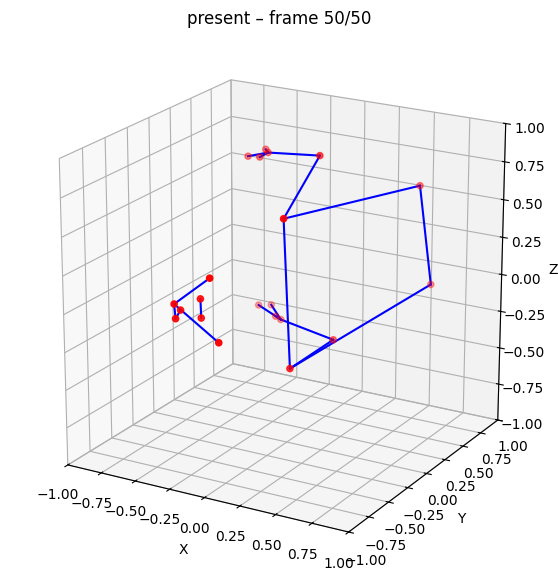

In [22]:
plot_stickman_3D("present")
